### Import Libraries

In [523]:
import pandas as pd
import numpy as np
import os
import datetime
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from scipy import stats

os.chdir(r'C:\Users\Akshay Gupta\Documents\Projects\Homescape\Vizualisations\Data')

### Import Tuya Data

In [524]:
meta=pd.read_csv(r'dev_loggers_tuya.csv')
data=pd.read_csv(r'dev_loggers_tuya_16Devices_backup.csv')
data['value']=data['value'].replace('true','1').replace('false','0')
data['value']=data['value'].astype(float)
data['event_time_utc']=pd.to_datetime(data['event_time_utc'])
data=data.drop_duplicates(subset=['device_id','event_timestamp','code','value'])
data.head()

,Unnamed: 0,property_id,device_id,code,event_from,event_id,event_timestamp,event_time_utc,status,value
0,0,22,bf603922278a45c9449gvo,cur_power,1,7,1603715463883,2020-10-26 12:31:03.883,1,125.0
1,1,22,bf603922278a45c9449gvo,cur_voltage,1,7,1603715463883,2020-10-26 12:31:03.883,1,2421.0
2,2,15,bf425667df5e89d62fhjvu,cur_power,1,7,1603705941104,2020-10-26 09:52:21.104,1,181.0
3,3,22,bf557926b9df9bf703acyh,cur_voltage,1,7,1603709237904,2020-10-26 10:47:17.904,1,2368.0
4,4,22,bff8ea23065e676885ikbk,cur_voltage,1,7,1603706019854,2020-10-26 09:53:39.854,1,2422.0


### Make Pivot Table

In [525]:
pivot_data=data.pivot_table(index=['property_id','device_id','event_time_utc'], columns='code', values='value')
pivot_data=pivot_data.reset_index()
pivot_data['Date']=[i.date() for i in pivot_data['event_time_utc']]

for i in range(1,len(pivot_data)):
    if np.isnan(pivot_data['cur_voltage'][i]) and np.isnan(pivot_data['switch_1'][i]):
        pivot_data.loc[i,'cur_voltage']=pivot_data['cur_voltage'].iloc[i-1]

pivot_data['Month'] = [i.month for i in pivot_data['event_time_utc']]
pivot_data['Week'] = [i.week for i in pivot_data['event_time_utc']]
pivot_data['Year'] = [i.year for i in pivot_data['event_time_utc']]
pivot_data.head()

code,property_id,device_id,event_time_utc,countdown_1,cur_current,cur_power,cur_voltage,switch_1,Date,Month,Week,Year
0,15,bf425667df5e89d62fhjvu,2020-08-25 16:52:54.698,NaN,NaN,NaN,NaN,1.0,2020-08-25,8,35,2020
1,15,bf425667df5e89d62fhjvu,2020-08-25 16:53:07.707,NaN,77.0,159.0,2443.0,NaN,2020-08-25,8,35,2020
2,15,bf425667df5e89d62fhjvu,2020-08-25 16:53:09.709,NaN,112.0,168.0,2443.0,NaN,2020-08-25,8,35,2020
3,15,bf425667df5e89d62fhjvu,2020-08-25 16:53:39.711,NaN,74.0,154.0,2434.0,NaN,2020-08-25,8,35,2020
4,15,bf425667df5e89d62fhjvu,2020-08-25 16:56:00.715,NaN,82.0,NaN,2386.0,NaN,2020-08-25,8,35,2020


### Function to get aggregated Energy and Time Stats per Property

In [526]:
def Get_Energy_and_Time_Usage(pivotdata , propid):
    device_usage=pd.DataFrame(index=[i.date() for i in pd.date_range(pivotdata['event_time_utc'].min(),pivotdata['event_time_utc'].max(), freq='H')],
                              columns=pivotdata['device_id'].unique())

    device_usage_energy=pd.DataFrame(index=[i.date() for i in pd.date_range(pivotdata['event_time_utc'].min(),pivotdata['event_time_utc'].max(), freq='H')],
                              columns=pivotdata['device_id'].unique())

    state=0
    pivotdata=pivotdata[pivotdata.property_id==propid].sort_values('event_time_utc')
    for device,df in pivotdata.groupby('device_id'):
        state=0
        prev_day_power=0
        for date in device_usage.index:
            temp=df[df['Date']==date][['event_time_utc','switch_1','cur_power']]
            time=pd.to_datetime(date)
            total_time=0
            total_energy=0
            for i in range(len(temp)):
                if state==1:
                    if temp['switch_1'].iloc[i]==0:
                        state=0
                        total_time=total_time+(temp['event_time_utc'].iloc[i]-pd.to_datetime(time)).seconds
                        time=temp['event_time_utc'].iloc[i]
                    elif temp['switch_1'].iloc[i]==1:
                        total_time=total_time+(temp['event_time_utc'].iloc[i]-pd.to_datetime(time)).seconds
                        time=temp['event_time_utc'].iloc[i]

                if state==0:
                    if temp['switch_1'].iloc[i]==0:
                        time=temp['event_time_utc'].iloc[i]
                    elif temp['switch_1'].iloc[i]==1:
                        state=1
                        time=temp['event_time_utc'].iloc[i]

                if np.isnan(temp['switch_1'].iloc[i]):
                    if (state==1) & (np.isnan(temp['cur_power'].iloc[i])==False):
                        if i==0:
                            total_energy=total_energy+(temp['event_time_utc'].iloc[i]-pd.to_datetime(date)).seconds*prev_day_power+(temp['event_time_utc'].iloc[i+1]-temp['event_time_utc'].iloc[i]).seconds*temp['cur_power'].iloc[i]/3600
                        elif i==len(temp)-1:
                            total_energy=total_energy+(pd.to_datetime(date)+datetime.timedelta(hours=1)-temp['event_time_utc'].iloc[i]).seconds*temp['cur_power'].iloc[i]/3600
                            prev_day_power=temp['cur_power'].iloc[i]
                        else:    
                            total_energy=total_energy+(temp['event_time_utc'].iloc[i+1]-temp['event_time_utc'].iloc[i]).seconds*temp['cur_power'].iloc[i]/3600


            if state == 1:
                total_time=total_time+(pd.to_datetime(date)-time +datetime.timedelta(hours=1)).seconds
            device_usage_energy.loc[date,device]=total_energy
            device_usage.loc[date,device]=total_time


    device_usage['Month'] = [pd.to_datetime(i).month for i in device_usage.index]
    device_usage['Week'] = [pd.to_datetime(i).week for i in device_usage.index]
    device_usage['Year'] = [pd.to_datetime(i).year for i in device_usage.index]
    device_usage['Date'] = [pd.to_datetime(i).date() for i in device_usage.index]
    device_usage_energy['Month'] = [pd.to_datetime(i).month for i in device_usage_energy.index]
    device_usage_energy['Week'] = [pd.to_datetime(i).week for i in device_usage_energy.index]
    device_usage_energy['Year'] = [pd.to_datetime(i).year for i in device_usage_energy.index]
    device_usage_energy['Date'] = [pd.to_datetime(i).date() for i in device_usage_energy.index]
    
    return device_usage_energy,device_usage

In [527]:
device_usage_energy,device_usage=Get_Energy_and_Time_Usage(pivot_data , 15)
device_usage_energy

,bf425667df5e89d62fhjvu,bfa9489885a2c54078s87z,bff9556124920d2b243e9f,bf0134d5ee7fcae5edmigl,bf77c5e5790a5ca71a3vjf,bfcb5ddd31910b7db0cata,bf557926b9df9bf703acyh,bf603922278a45c9449gvo,bfae35261c95f273054pxp,bff8ea23065e676885ikbk,Month,Week,Year,Date
2020-08-25,44640.8,0,83.9867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,35,2020,2020-08-25
2020-08-25,44640.8,0,83.9867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,35,2020,2020-08-25
2020-08-25,44640.8,0,83.9867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,35,2020,2020-08-25
2020-08-25,44640.8,0,83.9867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,35,2020,2020-08-25
2020-08-25,44640.8,0,83.9867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,35,2020,2020-08-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-26,16905.2,16224.5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,44,2020,2020-10-26
2020-10-26,16905.2,16224.5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,44,2020,2020-10-26
2020-10-26,16905.2,16224.5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,44,2020,2020-10-26
2020-10-26,16905.2,16224.5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,44,2020,2020-10-26


### Dashboard for Tuya Analytics

In [530]:
ALL = 'ALL'

def unique_sorted_values_plus_ALL(array):
    unique = array.unique().tolist()
    unique.sort()
    unique.insert(0, ALL)
    return unique

#dates = pd.date_range(pivot_data['event_time'].sort_values().iloc[0],pivot_data['event_time'].sort_values().iloc[-1], freq='h')
#options = [(i.strftime('%d %b'), i) for i in dates]

dropdown_feature = widgets.Dropdown(options = ['ALL','cur_current','cur_power', 'cur_voltage'],description = 'Feature')
dropdown_deviceid = widgets.Dropdown(options = unique_sorted_values_plus_ALL(pivot_data['device_id']), description='Device')
dropdown_propertyid = widgets.Dropdown(options = unique_sorted_values_plus_ALL(pivot_data['property_id']), description='Property')
dropdown_start_day = widgets.DatePicker(description='Start Date')
dropdown_end_day = widgets.DatePicker(description='End Date')
dropdown_aggregate=widgets.Dropdown(options = ['Day','Week', 'Month','Year'],description = 'Agg_Level')

output=widgets.Output()
plot_output=widgets.Output()
plot_aggregate_value=widgets.Output()
plot_aggregate_time=widgets.Output()

input_widgets = widgets.HBox([dropdown_propertyid,dropdown_start_day , dropdown_end_day, dropdown_deviceid, dropdown_feature,dropdown_aggregate],
                             layout=widgets.Layout(width='100%',display='inline-flex',flex_flow='row wrap'))
tab = widgets.Tab([output, plot_output,plot_aggregate_value,plot_aggregate_time])
tab.set_title(0, 'Dataset Exploration')
tab.set_title(1, 'Scatter Plot')
tab.set_title(2, 'Aggregate Value Usage')
tab.set_title(3, 'Aggregate Time Usage')

def common_filtering(propertyid,day1, day2, device, feature, aggregate):
    
    output.clear_output()
    plot_output.clear_output()
    plot_aggregate_value.clear_output()
    plot_aggregate_time.clear_output()
    if day1 and day2:

        if (device == ALL) & (day1 == ALL):
            common_filter = pivot_data
        elif (propertyid== ALL):
            common_filter = pivot_data[(pivot_data.event_time_utc >= pd.to_datetime(day1)) & (pivot_data.event_time_utc <= pd.to_datetime(day2)+datetime.timedelta(days=1)) & 
                                      (pivot_data.device_id == device)]
        elif (device == ALL):
            
            common_filter = pivot_data[(pivot_data.event_time_utc >= pd.to_datetime(day1)) & (pivot_data.event_time_utc <= pd.to_datetime(day2)+datetime.timedelta(days=1))
                                      & (pivot_data.property_id==propertyid)]
        elif (day1 == ALL):
            common_filter = pivot_data[(pivot_data.device_id == device) & (pivot_data.property_id==propertyid)]
        else:
            common_filter = pivot_data[(pivot_data.event_time_utc >= pd.to_datetime(day1)) & (pivot_data.event_time_utc <= pd.to_datetime(day2)+datetime.timedelta(days=1)) & 
                                      (pivot_data.device_id == device) & (pivot_data.property_id==propertyid)]

        with output:
            display(common_filter)
        with plot_output:

            fig,ax = plt.subplots()
            fig.set_size_inches(15,5)
            ax2 = ax.twinx()
            
            
            if feature == ALL:
                ax.plot(common_filter['event_time_utc'],common_filter[['cur_current','cur_power', 'cur_voltage']], lw=0, ms=2, marker='o')
            else:
                ax.plot(common_filter['event_time_utc'],common_filter[feature], 'g', lw=1, ms=2, marker='o')
            ax2.plot(common_filter['event_time_utc'],common_filter['countdown_1'], 'b', lw=0, ms=2, marker='o')
            ax2.plot(common_filter['event_time_utc'],common_filter['switch_1'], 'y', lw=0, ms=4, marker='o')

            ax.set_ylabel(feature, color='g')
            ax.set_xlabel('Event Time')
            ax2.set_ylabel('Countdown(blue) and Switch(yellow)', color='b')
            plt.show()
            
        with plot_aggregate_value:
            if feature == ALL:
                print('Select Feature to Aggregate')
            else:
                if aggregate=='Day':
                    aggregate='Date'
                fig,ax = plt.subplots()
                fig.set_size_inches(15,5)
                common_filter.pivot_table(index=aggregate, values=feature , aggfunc=np.sum).plot(kind='bar',ax=ax)
                plt.show()
                
        with plot_aggregate_time:
            if device == ALL:
                print('Select Device to Aggregate')
            else:
                if aggregate=='Day':
                    aggregate='Date'
                fig,ax = plt.subplots()
                fig.set_size_inches(15,5)
                device_usage[(device_usage['Date']>=day1) & (device_usage['Date']<=day2)].pivot_table(index=aggregate, values=device , aggfunc=np.sum).plot(kind='bar',ax=ax)
                plt.show()

    else: 
        with output:
            print('Select Start and End Date')

def dropdown_propertyid_eventhandler(change):
    common_filtering(change.new, dropdown_start_day.value,dropdown_end_day.value, dropdown_deviceid.value,
                     dropdown_feature.value,dropdown_aggregate.value)
def dropdown_start_day_eventhandler(change):
    common_filtering(dropdown_propertyid.value, change.new, dropdown_end_day.value, dropdown_deviceid.value,
                     dropdown_feature.value,dropdown_aggregate.value)
def dropdown_end_day_eventhandler(change):
    common_filtering(dropdown_propertyid.value, dropdown_start_day.value, change.new, dropdown_deviceid.value,
                     dropdown_feature.value,dropdown_aggregate.value)
def dropdown_device_eventhandler(change):
    common_filtering(dropdown_propertyid.value, dropdown_start_day.value, dropdown_end_day.value,change.new,
                     dropdown_feature.value,dropdown_aggregate.value)
def dropdown_feature_eventhandler(change):
    common_filtering(dropdown_propertyid.value, dropdown_start_day.value, dropdown_end_day.value, dropdown_deviceid.value, 
                     change.new,dropdown_aggregate.value)
def dropdown_aggregate_eventhandler(change):
    common_filtering(dropdown_propertyid.value, dropdown_start_day.value, dropdown_end_day.value, dropdown_deviceid.value, 
                     dropdown_feature.value,change.new)

dropdown_propertyid.observe(dropdown_propertyid_eventhandler, names='value')
dropdown_deviceid.observe(dropdown_device_eventhandler, names='value')
dropdown_start_day.observe(dropdown_start_day_eventhandler, names='value')
dropdown_end_day.observe(dropdown_end_day_eventhandler, names='value')
dropdown_feature.observe(dropdown_feature_eventhandler, names='value')
dropdown_aggregate.observe(dropdown_aggregate_eventhandler, names='value')

In [531]:
display(input_widgets)
display(tab)

In [191]:
temp=pivot_data[(pivot_data['device_id']=='bf425667df5e89d62fhjvu') & (pivot_data['Date']==pd.to_datetime('2020-10-16').date())].dropna(subset=['switch_1'])
temp.head(10)
state=0
time=pd.to_datetime('2020-10-16').date()
total_time=0

In [19]:
pivot_data['device_id'].unique()

array(['bff9556124920d2b243e9f', 'bf425667df5e89d62fhjvu',
       'bfa9489885a2c54078s87z', 'bf603922278a45c9449gvo',
       'bff8ea23065e676885ikbk', 'bf77c5e5790a5ca71a3vjf',
       'bfcb5ddd31910b7db0cata', 'bf557926b9df9bf703acyh',
       'bf0134d5ee7fcae5edmigl', 'bfae35261c95f273054pxp'], dtype=object)

In [23]:
time=pd.to_datetime(date)
total_time=0
total_energy=0
time_energy=pd.to_datetime(date)
for i in range(len(temp)):
    if state==1:
        if temp['switch_1'].iloc[i]==0:
            state=0
            total_time=total_time+(temp['event_time_utc'].iloc[i]-pd.to_datetime(time)).seconds
            time=temp['event_time_utc'].iloc[i]
        else:
            total_time=total_time+(temp['event_time_utc'].iloc[i]-pd.to_datetime(time)).seconds
            time=temp['event_time_utc'].iloc[i]
            time_energy=time

    if state==0:
        if temp['switch_1'].iloc[i]==0:
            time=temp['event_time_utc'].iloc[i]
        else:
            state=1
            time=temp['event_time_utc'].iloc[i]
            time_energy=time

    if np.isnan(temp['switch_1'].iloc[i]):
        if state==1:
            total_energy=total_energy+(temp['event_time_utc'].iloc[i]-time_energy)*temp['cur_power'].iloc[i]
            time_energy=temp['event_time_utc'].iloc[i]



if state == 1:
    total_time=total_time+(pd.to_datetime(date)-time +datetime.timedelta(days=1)).seconds
    if len(temp)==0:
        device_usage_energy.loc[date,device]=0
    else:
        total_energy=total_energy+(pd.to_datetime(date)-time_energy +datetime.timedelta(days=1))*temp['cur_power'].iloc[i]
        device_usage_energy.loc[date,device]=total_energy
device_usage.loc[date,device]=total_time


code,property_id,device_id,event_time_utc,countdown_1,cur_current,cur_power,cur_voltage,switch_1,Date,Month,Week,Year
0,15,bf425667df5e89d62fhjvu,2020-08-25 16:52:54.698,NaN,NaN,NaN,NaN,1.0,2020-08-25,8,35,2020
1,15,bf425667df5e89d62fhjvu,2020-08-25 16:53:07.707,NaN,77.0,159.0,2443.0,NaN,2020-08-25,8,35,2020
2,15,bf425667df5e89d62fhjvu,2020-08-25 16:53:09.709,NaN,112.0,168.0,2443.0,NaN,2020-08-25,8,35,2020
3,15,bf425667df5e89d62fhjvu,2020-08-25 16:53:39.711,NaN,74.0,154.0,2434.0,NaN,2020-08-25,8,35,2020
4,15,bf425667df5e89d62fhjvu,2020-08-25 16:56:00.715,NaN,82.0,NaN,2386.0,NaN,2020-08-25,8,35,2020
...,...,...,...,...,...,...,...,...,...,...,...,...
115,15,bf425667df5e89d62fhjvu,2020-08-25 23:51:34.912,NaN,249.0,440.0,2452.0,NaN,2020-08-25,8,35,2020
116,15,bf425667df5e89d62fhjvu,2020-08-25 23:54:00.916,NaN,5566.0,5021.0,2470.0,NaN,2020-08-25,8,35,2020
117,15,bf425667df5e89d62fhjvu,2020-08-25 23:54:02.918,NaN,5595.0,10964.0,2470.0,NaN,2020-08-25,8,35,2020
118,15,bf425667df5e89d62fhjvu,2020-08-25 23:54:04.920,NaN,5873.0,12348.0,2470.0,NaN,2020-08-25,8,35,2020


In [253]:
time=pd.to_datetime('2020-08-25')
total_time=0
total_energy=0
time_energy=pd.to_datetime('2020-08-25')
temp=pivot_data[pivot_data['device_id']=='bf425667df5e89d62fhjvu']
temp=temp[temp['Date']==pd.to_datetime('2020-08-25')]
temp['cur_power']=temp['cur_power'].fillna(0)
state=0
cur_power=0
prev_day_power=0

In [261]:
i=1

In [262]:
if state==1:
    if temp['switch_1'].iloc[i]==0:
        state=0
        total_time=total_time+(temp['event_time_utc'].iloc[i]-pd.to_datetime(time)).seconds
        time=temp['event_time_utc'].iloc[i]
    elif temp['switch_1'].iloc[i]==1:
        total_time=total_time+(temp['event_time_utc'].iloc[i]-pd.to_datetime(time)).seconds
        time=temp['event_time_utc'].iloc[i]
        time_energy=time

In [263]:
print(time)
print(total_time)
print(state)

2020-08-25 16:52:54.698000
0
1


In [264]:
if state==0:
    if temp['switch_1'].iloc[i]==0:
        time=temp['event_time_utc'].iloc[i]
    elif temp['switch_1'].iloc[i]==1:
        state=1
        time=temp['event_time_utc'].iloc[i]
        time_energy=time

In [265]:
print(time)
print(total_time)
print(state)

2020-08-25 16:52:54.698000
0
1


In [266]:
if np.isnan(temp['switch_1'].iloc[i]):
    if (state==1) & (np.isnan(temp['cur_power'].iloc[i])==False):
        if i==0:
            total_energy=total_energy+(temp['event_time_utc'].iloc[i]-pd.to_datetime(date)).seconds*prev_day_power+(temp['event_time_utc'].iloc[i+1]-temp['event_time_utc'].iloc[i]).seconds*temp['cur_power'].iloc[i]/3600
        elif i==len(temp)-1:
            total_energy=total_energy+(pd.to_datetime(date)+datetime.timedelta(day=1)-temp['event_time_utc'].iloc[i]).seconds*temp['cur_power'].iloc[i]/3600
            prev_day_power=temp['cur_power'].iloc[i]
        else:    
            total_energy=total_energy+(temp['event_time_utc'].iloc[i+1]-temp['event_time_utc'].iloc[i]).seconds*temp['cur_power'].iloc[i]/3600

In [267]:
print(time_energy)
print(temp['event_time_utc'].iloc[i])
print(temp['cur_power'].iloc[i])
print(total_energy)
print(state)

2020-08-25 16:52:54.698000
2020-08-25 16:53:07.707000
159.0
0.08833333333333333
1


In [315]:
device_usage_energy.index = pd.to_datetime(device_usage_energy.index)
device_usage_energy.fillna(0).resample("2h").mean()

,bf425667df5e89d62fhjvu,bfa9489885a2c54078s87z,bff9556124920d2b243e9f,bf0134d5ee7fcae5edmigl,bf77c5e5790a5ca71a3vjf,bfcb5ddd31910b7db0cata,bf557926b9df9bf703acyh,bf603922278a45c9449gvo,bfae35261c95f273054pxp,bff8ea23065e676885ikbk,Month,Week,Year
2020-08-25 00:00:00,44640.834444,0.000000,83.986667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,35.0,2020.0
2020-08-25 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-25 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-25 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-25 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-25 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-25 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-25 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-25 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [338]:
pivot_data=pivot_data.sort_values('event_time_utc').set_index('event_time_utc')

In [339]:
pivot_data['cur_energy']=0

In [455]:
pivot_data['cur_energy']=0
for device,df in pivot_data.groupby('device_id'):
    df=df[['cur_power','cur_energy','switch_1']].groupby(level=0).max()
    df.cur_power=df.cur_power.fillna(0)
    state=0
    for i,j in zip(df.index[:-1],df.index[1:]):
        if i!=j:
            if (np.isnan(df.loc[i,'switch_1'])==True) and (state==1):
                pivot_data.loc[(pivot_data['device_id']==device) & (pivot_data.index==i),'cur_energy']=(j-i).seconds/3600*df.loc[i,'cur_power']
            else:
                state=df.loc[i,'switch_1']
            
            

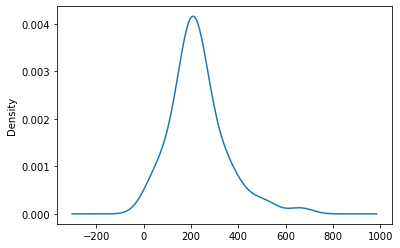

In [487]:
plot_df=pivot_data.loc[pivot_data['device_id']=='bf425667df5e89d62fhjvu']['cur_energy'].fillna(0)
plot_df[(np.abs(stats.zscore(plot_df))) < 3].resample('1D').mean().plot.kde()

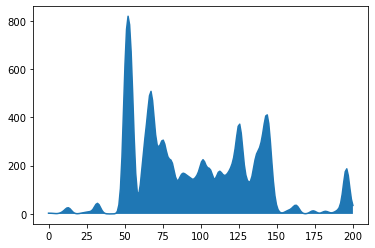

In [519]:
from scipy.ndimage.filters import gaussian_filter1d
x=plot_df[((plot_df.mean()-3*plot_df.std())<plot_df) & (plot_df<(plot_df.mean()+3*plot_df.std()))].resample('5min').mean().fillna(0)
x=x[:200]

xnew = np.linspace(0, len(x), len(x))

spl = gaussian_filter1d(x, sigma=2)

plt.plot(xnew, spl)
plt.fill_between(xnew,spl)
plt.show()


device='bf425667df5e89d62fhjvu'

In [429]:
df=df[['cur_power','cur_energy','switch_1']].groupby(level=0).max()
df.cur_power=df.cur_power.fillna(0)
state=0

In [434]:
i=df.index[1]
j=df.index[2]

In [435]:
if (np.isnan(df.loc[i,'switch_1'])==True) and (state==1):
    pivot_data.loc[(pivot_data['device_id']==device) & (pivot_data.index==i),'cur_energy']=(j-i).seconds/3600*df.loc[i,'cur_power']
else:
    state=df.loc[i,'switch_1']
    print(state)

C:\Users\Akshay Gupta\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [436]:
print(pivot_data[pivot_data['device_id']==device][['cur_power','cur_energy','switch_1']].sort_index())
print(df)

code                     cur_power  cur_energy  switch_1
event_time_utc                                          
2020-08-25 16:52:54.698        NaN           0       1.0
2020-08-25 16:53:07.707      159.0           0       NaN
2020-08-25 16:53:09.709      168.0           0       NaN
2020-08-25 16:53:39.711      154.0           0       NaN
2020-08-25 16:56:00.715        NaN           0       NaN
...                            ...         ...       ...
2020-10-26 08:49:04.562      184.0           0       NaN
2020-10-26 08:52:20.541      180.0           0       NaN
2020-10-26 09:52:21.104      181.0           0       NaN
2020-10-26 10:52:22.631      182.0           0       NaN
2020-10-26 11:52:23.119        NaN           0       NaN

[17336 rows x 3 columns]
code                     cur_power  cur_energy  switch_1
event_time_utc                                          
2020-08-25 16:52:54.698        0.0           0       1.0
2020-08-25 16:53:07.707      159.0           0       NaN
2020-

In [426]:
df=pivot_data[pivot_data['device_id']==device]
df

code,property_id,device_id,countdown_1,cur_current,cur_power,cur_voltage,switch_1,Date,Month,Week,Year,cur_energy
event_time_utc,,,,,,,,,,,,
2020-08-25 16:52:54.698,15,bf425667df5e89d62fhjvu,NaN,NaN,NaN,NaN,1.0,2020-08-25,8,35,2020,0
2020-08-25 16:53:07.707,15,bf425667df5e89d62fhjvu,NaN,77.0,159.0,2443.0,NaN,2020-08-25,8,35,2020,0
2020-08-25 16:53:09.709,15,bf425667df5e89d62fhjvu,NaN,112.0,168.0,2443.0,NaN,2020-08-25,8,35,2020,0
2020-08-25 16:53:39.711,15,bf425667df5e89d62fhjvu,NaN,74.0,154.0,2434.0,NaN,2020-08-25,8,35,2020,0
2020-08-25 16:56:00.715,15,bf425667df5e89d62fhjvu,NaN,82.0,NaN,2386.0,NaN,2020-08-25,8,35,2020,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-26 08:49:04.562,15,bf425667df5e89d62fhjvu,NaN,89.0,184.0,2532.0,NaN,2020-10-26,10,44,2020,0
2020-10-26 08:52:20.541,15,bf425667df5e89d62fhjvu,NaN,80.0,180.0,2546.0,NaN,2020-10-26,10,44,2020,0
2020-10-26 09:52:21.104,15,bf425667df5e89d62fhjvu,NaN,81.0,181.0,2551.0,NaN,2020-10-26,10,44,2020,0


In [437]:
(j-i).seconds/3600*df.loc[i,'cur_power']

0.08833333333333333

In [453]:
pivot_data.loc[(pivot_data['device_id']==device) & (pivot_data.index==i),'cur_energy']=(j-i).seconds/3600*df.loc[i,'cur_power']

In [454]:
pivot_data[pivot_data['device_id']==device].loc[i,'cur_energy']

0.08833333333333333

In [452]:
pivot_data.loc[(pivot_data['device_id']==device) & (pivot_data.index==i),'cur_energy']

event_time_utc
2020-08-25 16:53:07.707    0
Name: cur_energy, dtype: int64